# Pretraining Data Encoding

In [1]:
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Assuming your notebook's working directory is set such that ../llm-tokenizer is reachable:
tokenizer_dir = os.path.abspath(os.path.join(os.getcwd(), '../llm-tokenizer'))
if tokenizer_dir not in sys.path:
    sys.path.insert(0, tokenizer_dir)

import BPETokenizer  # Now you should be able to import it

In [3]:
import torch
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available else 'cpu'

In [4]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Feb 21 08:21:18 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   44C    P8    15W / 140W |      1MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from GPT import GPT, GPTConfig

config = GPTConfig
config.batch_size = 1024
config.block_size = 64
config.epochs = 10000
config.validation_frequency = 20
config.validation_epochs = 4

In [14]:
class DataLoader:
    def __init__(self, config):
        
        self.config = config

        with open('input.txt', 'r') as f:
            text = f.read()
        len(text)

        tokenizer = BPETokenizer.Tokenizer(text, encoding_vocab_size=2000, raw_tokens=False)
        tokenizer.load_from_file()
        encoded_dataset = tokenizer.encode(text, raw_tokens=False)
        print(f"max vocabulary size={max(encoded_dataset)}, compression ratio={len(encoded_dataset) / len(text)}")
        split = int(len(encoded_dataset) * 0.80)
        self.train_data =  torch.tensor(encoded_dataset[:split])
        self.val_data = torch.tensor(encoded_dataset[split+config.block_size:])
        print(f"train_data.shape={self.train_data.shape}, val_data.shape={self.val_data.shape}")
        
        self.train_data_ix = 0
        self.val_data_ix = 0
        self.batch_step = self.config.batch_size * self.config.block_size 
        
    def next_batch(self, mode="train", device=device):
        """ mode=["train", "eval"] """
        if mode == "train":
            x, y = self._next_batch_train()
        else:
            x, y = self._next_batch_eval()
        return x.to(device), y.to(device)
    
    def _next_batch_train(self):
        
        data = self.train_data
        ix = self.train_data_ix 
        
        buf = data[ix:ix+self.batch_step + 1]     
        x = buf[:-1].view(self.config.batch_size, self.config.block_size)
        y = buf[1:].view(self.config.batch_size, self.config.block_size)
        
        self.train_data_ix += self.batch_step 
        if self.train_data_ix + self.batch_step + 1 > len(self.train_data):
            self.train_data_ix = 0
        
        return x, y
    
    def _next_batch_eval(self):
        
        data = self.val_data
        ix = self.val_data_ix 
        
        buf = data[ix:ix+self.batch_step + 1]     
        x = buf[:-1].view(self.config.batch_size, self.config.block_size)
        y = buf[1:].view(self.config.batch_size, self.config.block_size)
        
        self.val_data_ix += self.batch_step 
        if self.val_data_ix + self.batch_step + 1 > len(self.val_data):
            self.val_data_ix = 0
        
        return x, y
    

        
        



In [15]:
data_loader = DataLoader(config)
data_loader.next_batch()

max vocabulary size=2213, compression ratio=0.4458684554516162
train_data.shape=torch.Size([397855]), val_data.shape=torch.Size([99400])


(tensor([[  70,  299,  296,  ...,  275,  267,   82],
         [ 280,  403, 1410,  ...,   70,  299,  296],
         [  32, 1709,   76,  ...,  274,  260, 1709],
         ...,
         [  79,  491, 2051,  ...,  467,  394,  360],
         [ 595,  104,  549,  ...,  594,  288,  316],
         [ 104,  290,  320,  ...,  335,  424,   32]], device='cuda:0'),
 tensor([[ 299,  296,   32,  ...,  267,   82,  280],
         [ 403, 1410,  100,  ...,  299,  296,   32],
         [1709,   76,  453,  ...,  260, 1709, 1045],
         ...,
         [ 491, 2051,  856,  ...,  394,  360,  595],
         [ 104,  549,  774,  ...,  288,  316,  104],
         [ 290,  320,  359,  ...,  424,   32,   82]], device='cuda:0'))

In [16]:
x, y = data_loader.next_batch()
x1, y = data_loader.next_batch()
assert x[0][0] != x1[0][0]
x.shape, y.shape

(torch.Size([1024, 64]), torch.Size([1024, 64]))

In [17]:
x, y = data_loader.next_batch(mode="eval")
x1, y = data_loader.next_batch(mode="eval")
assert x[0][0] != x1[0][0]
x.shape, y.shape

AssertionError: 

# Training

In [19]:
import torch

import gc
gc.collect()

#del X_tr
#del y_tr

l = locals().items()
for name, obj in l:
    try:
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            print(f"{name}: shape={obj.shape}, device={obj.device}")
    except Exception as e:
        pass
    


x: shape=torch.Size([1024, 64]), device=cuda:0
y: shape=torch.Size([1024, 64]), device=cuda:0
x1: shape=torch.Size([1024, 64]), device=cuda:0


In [20]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Feb 21 08:23:10 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   45C    P2    37W / 140W |    191MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
model = GPT(config)
model.to(device)
print(sum(p.numel() for p in model.parameters()))

162299904


In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)
# train_losses, val_losses = [], []
bb = config.batch_size * config.block_size

for epoch in range(config.epochs):
    optimizer.zero_grad()
    X, y = data_loader.next_batch()
    logits = model(X)
    train_loss = F.cross_entropy(logits.view(bb, -1), y.view(bb))
    train_losses.append(train_loss.item())
    train_loss.backward()
    optimizer.step()
    
    if epoch % config.validation_frequency == 0:
        model.eval()
        with torch.no_grad():
            epoch_val_losses = []
            for _ in range(config.validation_epochs):
                X, y = data_loader.next_batch(mode="eval")
                logits = model(X)
                val_loss = F.cross_entropy(logits.view(bb, -1), y.view(bb))
                epoch_val_losses.append(val_loss)
            val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
            model.train()
    
    
  
            val_losses.append(val_loss)
            print(f"[{epoch}/{config.epochs}] train_loss={train_loss.item():.2f}, val_loss={val_loss:.2f}")

# [880/10000] train_loss=3.59, val_loss=4.00

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 15.73 GiB of which 57.12 MiB is free. Process 3475790 has 15.67 GiB memory in use. Of the allocated memory 15.29 GiB is allocated by PyTorch, and 192.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

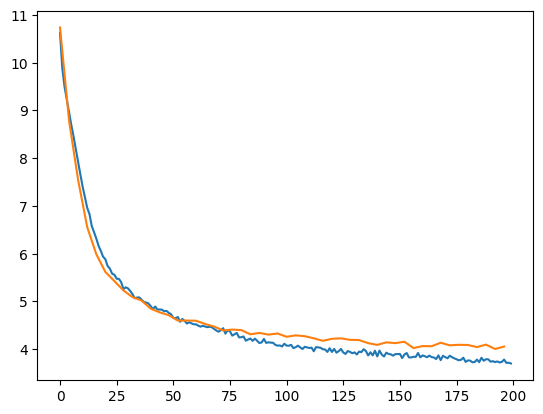

In [38]:
from matplotlib import pyplot as plt
gap = 4
plot_size = gap * len(val_losses)
val_losses = [t.cpu() for t in val_losses]
clip = (len(train_losses) // plot_size) * plot_size

plt.plot(torch.tensor(train_losses[:clip]).view(plot_size, - 1).mean(1))
plt.plot([i * gap for i, _ in enumerate(val_losses)], val_losses)
plt.show()

# Generation

In [188]:
prompt = " "
tokens = tokenizer.encode(prompt, raw_tokens=False)
tokens
model.eval()
x = torch.tensor(tokens[:config.block_size], device=device).view(1, -1)
x
    

tensor([[32]], device='cuda:0')

In [189]:
to_decode = x.tolist()[0]
for _ in range(500):
    
    x = x[-config.block_size:]

    logits = model(x.view(1, -1))
    
    new_token = torch.multinomial(F.softmax(logits[0, -1, :], dim=0),  1)
    v, ixs = logits[0, -1, :].topk(50)
    ix = torch.multinomial(F.softmax(v, dim=0), 1)
    new_token = ixs[ix]
    to_decode.append(new_token.view(-1).item())
    x = torch.cat([x.view(-1), new_token])

print(tokenizer.decode(to_decode, raw_tokens=False))

 unes of bratry arms they guk'd, in.

KING HENRY VI:
Can, how lorims good!

Second now, man:
First nothing, my lord by thy seve thore.
'Tis true that hason'd is be to dide is kinlnelk tharideed?

LEONTES:
Lest are your pas it: but I excesterntak to hese should all orself them!
I murp, by SON:
A more before his
country nor say'd flame, I will heard to vain!
You former grace, deempes widow his down when never shere,
If ithere is chan with is it fiel me,
Make bellaining the coward.

Pethle sindom you hontal king touch
And memust and a tion the is over buthow
Hereforry restrist him. I kneet
By hear's life,
As the princence it fling-would liberse that you and and stubirst thee?

LORY:
O, now Clow excus, in blead?

Were my hese birst now a which have thou not for here?

Pold now it Call missue,
Alauding.

LORICHARD III:
That a gentlemarsless plus, what why, that I welse Gontain the mayer the worl are dir should te thee bider.

A four generall, my so Feather:
But thou shalt not so.
What non, 

In [180]:
prompt = "First Citizen:"
tokens = tokenizer.encode(prompt, raw_tokens=False)
tokenizer.decode(tokens, raw_tokens=False)

'First Citizen:'

# Evaluation

In [201]:
X_val.shape, y_val.shape

(torch.Size([24737, 64]), torch.Size([24737, 64]))

In [215]:
samples = 20
y_pred = model(X_val[:samples])
y_pred = torch.argmax(F.softmax(y_pred, dim=2), dim=2)
y_val = y_val[:samples]
val, counts = torch.unique((y_pred == y_val).view(-1), return_counts=True)
assert val[1] == True
print(f"({samples * config.batch_size} samples) precision={counts[1] / (counts[0] + counts[1]).item():.3f}%")

(640 samples) precision=0.226%


In [ ]:
# (640 samples) precision=0.226%